In [1]:
import os 
import sys 

sys.path.insert(0, '..')

from process_bigraph import Composite
from process_bigraph.experiments.parameter_scan import RunProcess

from biosimulator_processes.processes.amici_process import AmiciUTC
from biosimulator_processes import CORE 
from biosimulator_processes.utils import plot_utc_outputs

Available processes:
[ 'console-emitter',
  'ram-emitter',
  'composite',
  'cobra',
  'copasi',
  'tellurium',
  'amici']
Available processes:
[ 'console-emitter',
  'ram-emitter',
  'composite',
  'cobra',
  'copasi',
  'tellurium',
  'amici',
  'copasi-step',
  'tellurium-step',
  'amici-step',
  'plotter',
  'plotter2d']


In [2]:
omex_dirpath = './examples/sbml-core/Elowitz-Nature-2000-Repressilator'
model_path = os.path.join(omex_dirpath, 'BIOMD0000000012_url.xml')
reports_path = os.path.join(omex_dirpath, 'reports.h5')

obs1 = ["floating_species_concentrations", "ci_protein"]
proc_addresses = ['copasi', 'tellurium', 'amici']
proc_address = 'amici'

amici_process_config = {
    'model': {'model_source': omex_dirpath},
    # 'time_config': {'step_size': 0.2, 'duration': 1000, 'num_steps': 5001}
}

In [3]:
amici_process = AmiciUTC(config=amici_process_config)

2024-05-29 03:02:13.824 - amici.sbml_import - INFO - Finished importing SBML                         (5.64E-02s)
2024-05-29 03:02:13.883 - amici.sbml_import - INFO - Finished processing SBML observables            (5.47E-02s)
2024-05-29 03:02:13.887 - amici.sbml_import - INFO - Finished processing SBML event observables      (4.17E-07s)
2024-05-29 03:02:13.918 - amici.de_model - INFO - Finished computing xdot                            (5.51E-03s)
2024-05-29 03:02:13.928 - amici.de_model - INFO - Finished computing x0                              (3.77E-03s)
2024-05-29 03:02:13.964 - amici.de_model - INFO - Finished computing w                               (3.33E-02s)
2024-05-29 03:02:14.762 - amici.de_export - INFO - Finished generating cpp code                      (7.86E-01s)
2024-05-29 03:02:25.716 - amici.de_export - INFO - Finished compiling cpp code                       (1.09E+01s)


In [4]:
results = amici_process.update()

In [5]:
results

{'time': array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
         66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
         77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
         88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
         99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
        110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
        121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
        132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
        143., 144., 145., 146.

In [6]:
from biosimulator_processes.io import get_sedml_time_config

get_sedml_time_config(os.path.join(omex_dirpath, 'simulation.sedml'))

{'id': 'simulation',
 'initialTime': '0',
 'outputStartTime': '400',
 'outputEndTime': '1000',
 'numberOfPoints': '600',
 'algorithm': 'KISAO:0000019'}

<Axes: >

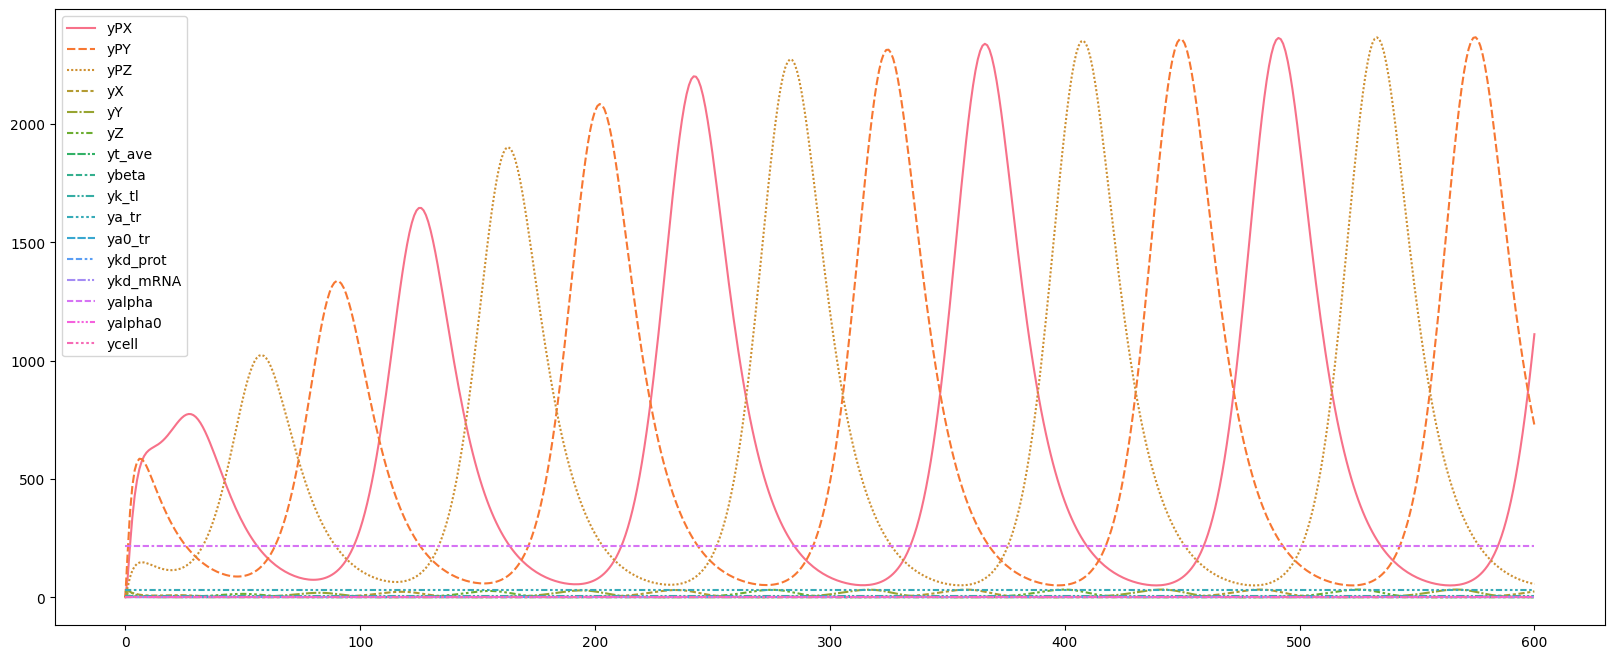

In [7]:
plot_utc_outputs(results, simulator_name='Amici')

In [8]:
from biosimulator_processes.api.compare import generate_comparison
import numpy as np 

vals =  [v for k, v in results['floating_species_concentrations'].items()]



In [9]:
len(vals)

16

In [10]:
from biosimulator_processes.io import read_report_outputs

In [11]:
len(read_report_outputs(reports_path).data)

7

In [12]:
from biosimulator_processes.api.compare import exec_compare
    

In [14]:
save_dir = '../test_outputs/simple-amici-comparison'
exec_compare(reports_path, results, save_dir)

In [15]:
!ls ../test_outputs

simple-amici-comparison              test_ode_comparator_step_result.txt
test_ode_comparator_step_result.json test_ode_comparison_object.json
